# Préparation du Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
import cv2
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import spacy

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
# Chemin vers le fichier CSV contenant les données de catégories
csv_path = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/Dataset_projet_pretraitement_textes_images/Flipkart/flipkart_com-ecommerce_sample_1050_Champ.csv'
data = pd.read_csv("C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/Dataset_projet_pretraitement_textes_images/Flipkart/flipkart_com-ecommerce_sample_1050_Champ.csv")
data_fusionne = pd.read_csv("C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/Dataset_projet_pretraitement_textes_images/Flipkart/flipkart_com-ecommerce_sample_1050_Champ.csv")

# Chargement du DataFrame qui contient les informations des produits, y compris 'product_category_tree'
df_categories = pd.read_csv(csv_path)

# Fonction pour extraire la première catégorie de 'product_category_tree'
def get_first_category(category_tree):
    if category_tree.startswith('["'):
        categories = category_tree[2:-2].split(' >> ')
        if categories:
            return categories[0]
    return None

# Appliquer la fonction pour créer une nouvelle colonne 'first_category'
df_categories['first_category'] = df_categories['product_category_tree'].apply(get_first_category)
data['first_category'] = data['product_category_tree'].apply(get_first_category)

# Chemin vers le dossier des images
images_path = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/Dataset_projet_pretraitement_textes_images/Flipkart/Images/'

# Récupération des chemins des images
#data_path = glob(os.path.join(images_path, '*.jpg'))
data_path = [path for path in glob(os.path.join(images_path, '*.jpg'))
             if os.path.splitext(os.path.basename(path))[0] in set(data['uniq_id']).union(set(data_fusionne['uniq_id']))]
# Création d'un DataFrame pour les chemins des images avec leur uniq_id
df_images = pd.DataFrame({
    'image_path': data_path,
    'uniq_id': [os.path.splitext(os.path.basename(path))[0] for path in data_path]
})

# Fonction pour obtenir la catégorie à partir de l'identifiant unique
def photo_class(uniq_id):
    category = df_categories.loc[df_categories['uniq_id'] == uniq_id, 'first_category'].values
    if category.size > 0:
        return category[0]
    return "no_name"

# Liste des catégories valides
list_labels = ["Baby Care", "Beauty and Personal Care", "Computers", "Home Decor & Festive Needs", "Home Furnishing", "Kitchen & Dining", "Watches",]

# Associer les catégories aux images
df_images['label_name'] = df_images['uniq_id'].apply(photo_class)

# Encoder les labels
le = preprocessing.LabelEncoder()
le.fit(df_images['label_name'])
df_images['label'] = le.transform(df_images['label_name'])

# Initialisation de la liste des scores ARI
scores_ari = []


In [3]:
# Charger le modèle anglais de spaCy
nlp = spacy.load('en_core_web_sm')

# Fonction pour nettoyer le texte
def clean_text(text):
    # Tokenisation du texte
    tokens = word_tokenize(text)
    # Suppression de la ponctuation et mise en minuscule
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # Suppression des mots vides (stop words)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Fonction pour appliquer le stemming
def stem_text(tokens):
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in tokens]
    return stemmed

# Fonction pour appliquer la lemmatisation
def lemmatize_text(tokens):
    doc = spacy.tokens.Doc(nlp.vocab, words=tokens)
    lemmatized = [token.lemma_ for token in nlp(doc)]
    return lemmatized

# Application des fonctions sur la colonne 'description'
data['description'] = data['description'].fillna('') 
data['cleaned_tokens'] = data['description'].apply(clean_text)
data['stemmed_tokens'] = data['cleaned_tokens'].apply(stem_text)
data['lemmatized_tokens'] = data['cleaned_tokens'].apply(lemmatize_text)

In [4]:
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Fonction pour nettoyer le texte
def clean_text(text):
    print(f"Original: {text}")
    # Tokenisation du texte
    tokens = word_tokenize(text)
    print(f"Tokenized: {tokens}")
    # Suppression de la ponctuation et mise en minuscule
    tokens = [word.lower() for word in tokens if word.isalpha()]
    print(f"Lowercase and punctuation removed: {tokens}")
    # Suppression des mots vides (stop words)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    print(f"Stop words removed: {tokens}")
    return tokens

# Fonction pour appliquer le stemming
def stem_text(tokens):
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in tokens]
    print(f"Stemmed: {stemmed}")
    return stemmed

# Fonction pour appliquer la lemmatisation
def lemmatize_text(tokens):
    doc = spacy.tokens.Doc(nlp.vocab, words=tokens)
    lemmatized = [token.lemma_ for token in nlp(doc)]
    print(f"Lemmatized: {lemmatized}")
    return lemmatized

# Exemple de texte
sample_text = "Children playing in the park are often happier than those studying detailed historical events."
tokens = clean_text(sample_text)
stemmed = stem_text(tokens)
lemmatized = lemmatize_text(tokens)


Original: Children playing in the park are often happier than those studying detailed historical events.
Tokenized: ['Children', 'playing', 'in', 'the', 'park', 'are', 'often', 'happier', 'than', 'those', 'studying', 'detailed', 'historical', 'events', '.']
Lowercase and punctuation removed: ['children', 'playing', 'in', 'the', 'park', 'are', 'often', 'happier', 'than', 'those', 'studying', 'detailed', 'historical', 'events']
Stop words removed: ['children', 'playing', 'park', 'often', 'happier', 'studying', 'detailed', 'historical', 'events']
Stemmed: ['children', 'play', 'park', 'often', 'happier', 'studi', 'detail', 'histor', 'event']
Lemmatized: ['child', 'play', 'park', 'often', 'happy', 'study', 'detailed', 'historical', 'event']


# Image

## Mise En Place

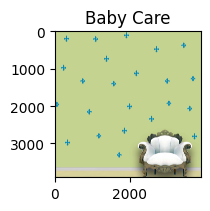

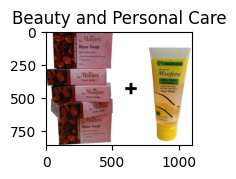

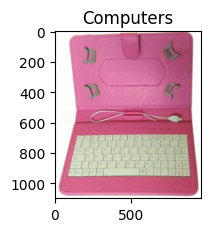

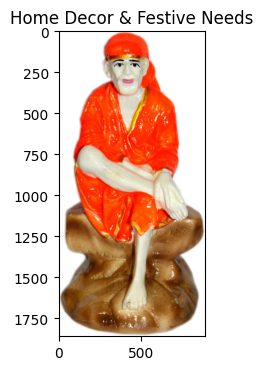

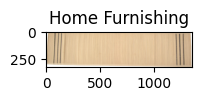

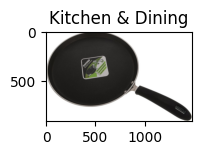

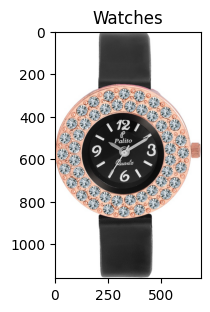

In [5]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]==name]
    return list_image_name

list_BC=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Baby Care"]
list_BPC=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Beauty and Personal Care"]
list_Computers=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Computers"]
list_HDFN=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Home Decor & Festive Needs"]
list_HF=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Home Furnishing"]
list_KD=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Kitchen & Dining"]
list_Watches=[df_images["image_path"][i] for i in range(len(df_images)) if df_images["label_name"][i]=="Watches"]

for category in list_labels:
    # Obtenez la liste des images pour la catégorie actuelle
    list_images = list_fct(category)
    # Affichez jusqu'à 1 images de cette catégorie
    for i in range(1):
        if i < len(list_images):
            filename = list_images[i]
            image = imread(filename)
            plt.subplot(130 + 1 + i)
            plt.imshow(image)
            plt.title(category)  # Ajoutez un titre pour identifier la catégorie
    plt.show()

## Création du modèle VGG16

In [43]:
def process_image(file_path):
    # Lire l'image en mode couleur, réduction de bruit et amélioration du contraste
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224))  # Redimensionnement pour VGG16
    img = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)  # Réduction de bruit
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    final_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final_img

In [44]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [45]:
# Traitement des images et extraction des caractéristiques
images_features = []
for i, image_file in enumerate(df_images["image_path"]):
    if i % 100 == 0:
        print(f'Processing image {i}...')
    image = process_image(image_file)  # Appliquer les prétraitements personnalisés
    image = img_to_array(image)  # Convertir l'image traitée en tableau
    image = np.expand_dims(image, axis=0)  # Agrandir l'image pour VGG16
    image = preprocess_input(image)  # Prétraitement spécifique à VGG16
    images_features.append(model.predict(image, verbose=0)[0])  # Extraction de caractéristiques

images_features = np.asarray(images_features)
print(images_features.shape)

Processing image 0...
Processing image 100...
Processing image 200...
Processing image 300...
Processing image 400...
Processing image 500...
Processing image 600...
Processing image 700...
Processing image 800...
Processing image 900...
Processing image 1000...
(1050, 4096)


In [46]:
# Les étiquettes ont déjà été encodées dans df_images['label']
labels = df_images['label'].values

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(images_features, labels, test_size=0.2, random_state=42)

# Entraîner un classificateur Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Évaluer le modèle
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.8238095238095238


In [47]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 800)


In [48]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=42, n_iter=1000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :            11.64 secondes


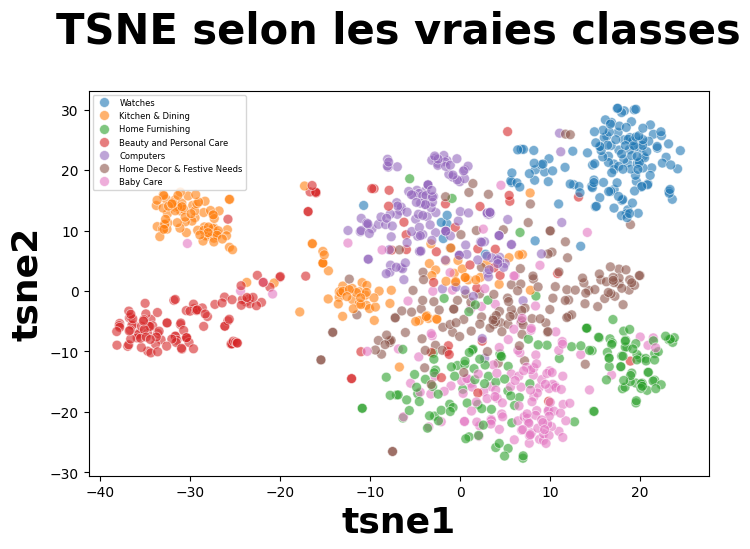

In [49]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_images["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 6}) 

plt.show()


In [50]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

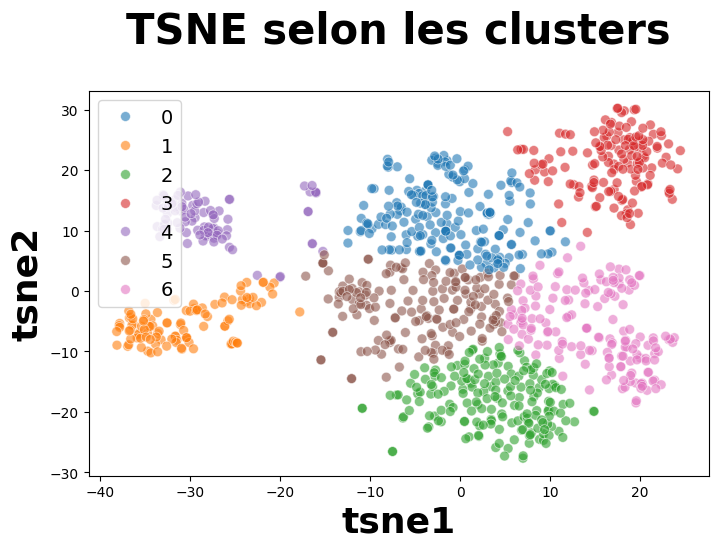

ARI :  0.44458357814404914


In [51]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_images["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

# Calcul de l'ARI score
ARI_score = metrics.adjusted_rand_score(labels, cls.labels_)
scores_ari.append(('VGG16', ARI_score))


In [52]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[  4   3 105   1   1  15  21]
 [ 18 102   3   2  11  12   2]
 [128   0   1   3   0  17   1]
 [ 18   0   8   3   0  58  63]
 [  3   0  69   0   0   8  70]
 [  9   3   0   0  80  57   1]
 [ 12   0   0 137   0   0   1]]


In [53]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [54]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [2 1 0 6 5 3 4]
[[105   3   4  15  21   1   1]
 [  3 102  18  12   2  11   2]
 [  1   0 128  17   1   0   3]
 [  8   0  18  58  63   0   3]
 [ 69   0   3   8  70   0   0]
 [  0   3   9  57   1  80   0]
 [  0   0  12   0   1   0 137]]

              precision    recall  f1-score   support

           0       0.56      0.70      0.62       150
           1       0.94      0.68      0.79       150
           2       0.67      0.85      0.75       150
           3       0.35      0.39      0.37       150
           4       0.44      0.47      0.45       150
           5       0.87      0.53      0.66       150
           6       0.94      0.91      0.93       150

    accuracy                           0.65      1050
   macro avg       0.68      0.65      0.65      1050
weighted avg       0.68      0.65      0.65      1050



<Axes: >

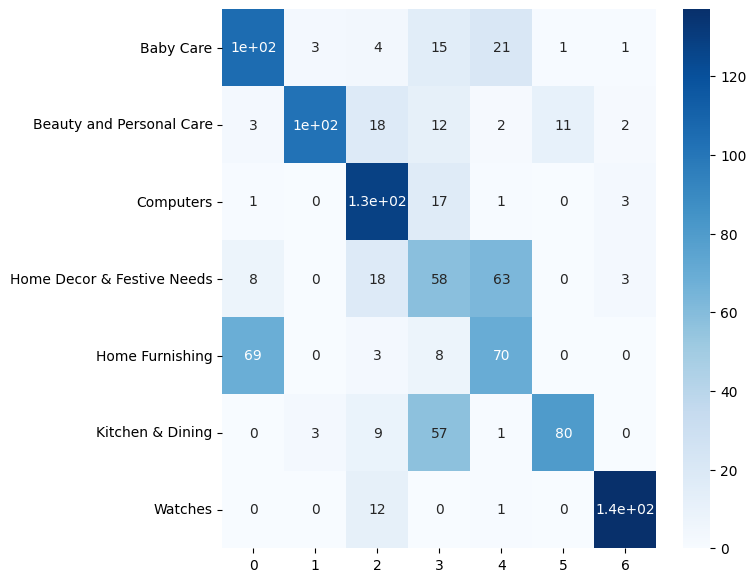

In [55]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## ORB

In [74]:
def extract_orb_features(image_path, descriptor_size=256):  # 256 pourrait être un choix, dépendant de vos observations des longueurs
    # Charger l'image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Initialiser ORB
    orb = cv2.ORB_create()
    # Trouver les keypoints et descripteurs avec ORB
    keypoints, descriptors = orb.detectAndCompute(img, None)
    # Transformer les descripteurs en un format utilisable si non vide
    if descriptors is not None:
        # Flatten the descriptors to ensure they are a single array
        descriptors = descriptors.flatten()
        # Ensure the descriptor is of a fixed size
        if len(descriptors) > descriptor_size:
            descriptors = descriptors[:descriptor_size]
        else:
            # Pad with zeros if below the desired size
            descriptors = np.pad(descriptors, (0, descriptor_size - len(descriptors)), 'constant')
    else:
        # Si aucun descripteur n'est trouvé, créez un vecteur de zéros
        descriptors = np.zeros(descriptor_size)
    return descriptors


In [75]:
features = []

# Itérer sur chaque chemin d'image dans le DataFrame
for image_path in df_images['image_path']:
    descriptors = extract_orb_features(image_path)
    features.append(descriptors)

# Convertir la liste de caractéristiques en un tableau NumPy pour l'utilisation dans des modèles d'apprentissage automatique
features_array = np.array(features)


In [76]:
# Les étiquettes ont déjà été encodées dans df_images['label']
labels = df_images['label'].values


In [77]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features_array, labels, test_size=0.2, random_state=42)

# Entraîner un classificateur Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Évaluer le modèle
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


Accuracy: 0.19047619047619047


In [79]:
from sklearn import manifold, decomposition

print(features_array.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(features_array)
print(feat_pca.shape)

(1050, 256)
(1050, 240)


In [80]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=42, n_iter=1000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :            82.89 secondes


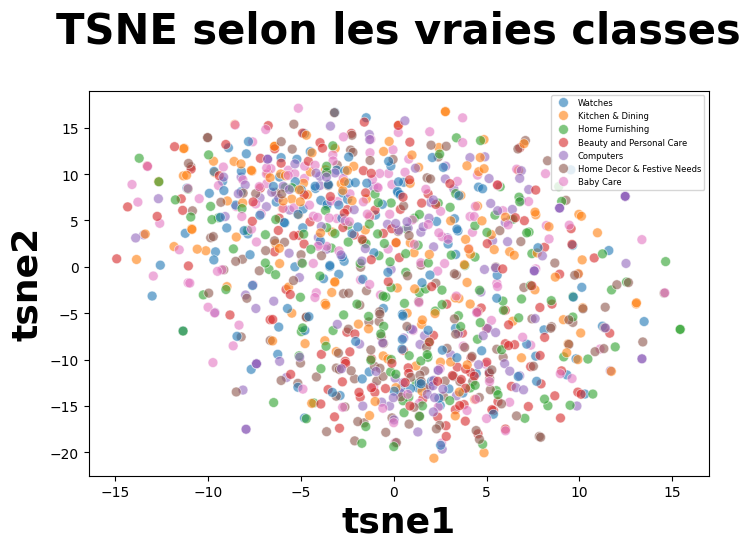

In [81]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_images["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 6}) 

plt.show()


In [82]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

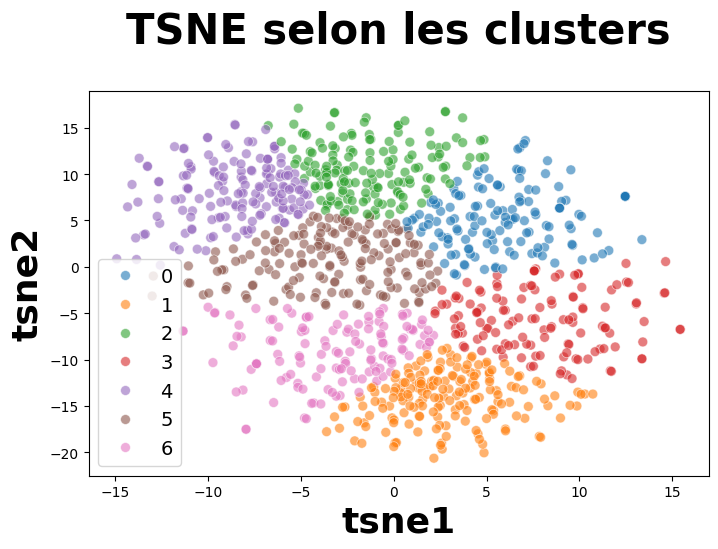

ARI :  0.01438103079503561


In [83]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_images["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

# Calcul de l'ARI score
ARI_score = metrics.adjusted_rand_score(labels, cls.labels_)
scores_ari.append(('ORB', ARI_score))


Correspondance des clusters :  [2 1 6 4 5 4 3]


<Axes: >

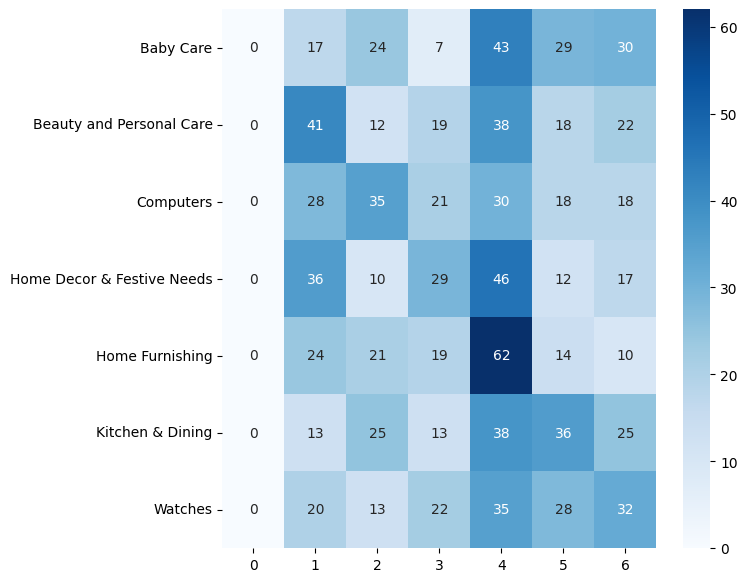

In [84]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)

def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap="Blues")


## SIFT

In [6]:
def extract_sift_features(image_path, descriptor_size=128, max_keypoints=500):
    # Charger l'image et convertir en niveaux de gris
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Vérifier si l'image est lue correctement
    if img is None:
        raise ValueError(f"Image at {image_path} could not be read.")

    # Redimensionner l'image pour réduire la consommation de mémoire
    scale_percent = 50  # pourcentage de la taille originale
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

    # Initialiser SIFT
    sift = cv2.SIFT_create(nfeatures=max_keypoints)  # Limiter le nombre de keypoints
    # Trouver les keypoints et descripteurs avec SIFT
    keypoints, descriptors = sift.detectAndCompute(img, None)

    # Calculer la taille maximale des descripteurs en fonction du nombre maximum de keypoints
    max_size = descriptor_size * max_keypoints

    # S'assurer que les descripteurs ont une taille fixe
    if descriptors is not None:
        descriptors = descriptors.flatten()
        if len(descriptors) > max_size:
            descriptors = descriptors[:max_size]
        else:
            descriptors = np.pad(descriptors, (0, max_size - len(descriptors)), 'constant')
    else:
        descriptors = np.zeros(max_size)

    return descriptors


In [7]:
features2 = []

# Itérer sur chaque chemin d'image dans le DataFrame
for image_path in df_images['image_path']:
    descriptors = extract_sift_features(image_path)
    features2.append(descriptors)

# Convertir la liste de caractéristiques en un tableau NumPy pour l'utilisation dans des modèles d'apprentissage automatique
features_array = np.array(features2)


In [8]:
# Les étiquettes ont déjà été encodées dans df_images['label']
labels = df_images['label'].values


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features_array, labels, test_size=0.2, random_state=42)

# Entraîner un classificateur Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Évaluer le modèle
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


Accuracy: 0.2571428571428571


In [11]:
from sklearn import manifold, decomposition
import time
print(features_array.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(features_array)
print(feat_pca.shape)

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=42, n_iter=1000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")



(1050, 64000)
(1050, 939)
temps de T-SNE :            12.13 secondes


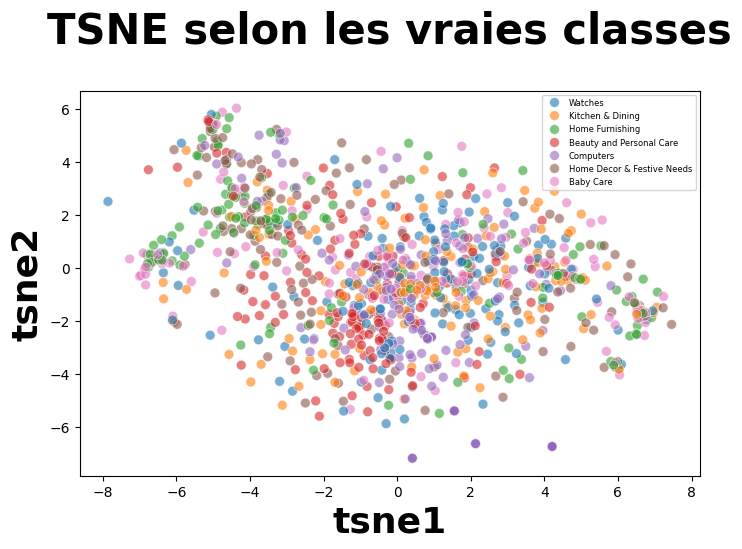

In [12]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_images["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 6}) 

plt.show()


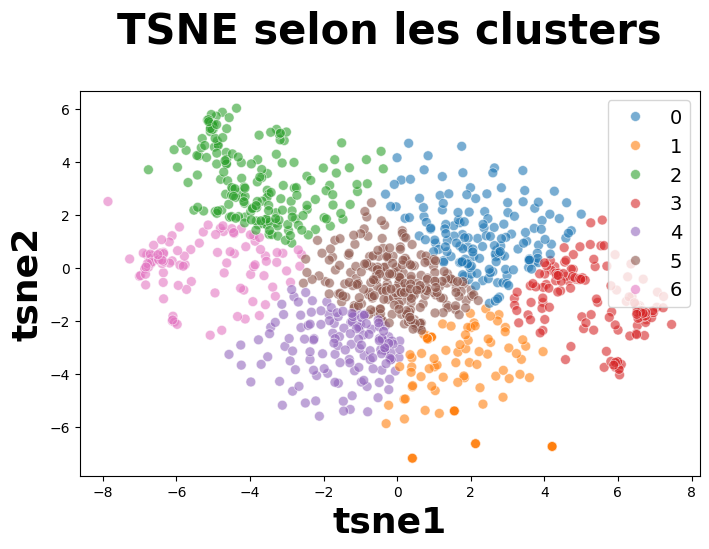

ARI :  0.05651833484376241


In [14]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_images["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

# Calcul de l'ARI score
ARI_score = metrics.adjusted_rand_score(labels, cls.labels_)
scores_ari.append(('SIFT', ARI_score))


Correspondance des clusters :  [6 2 4 4 1 2 0]


<Axes: >

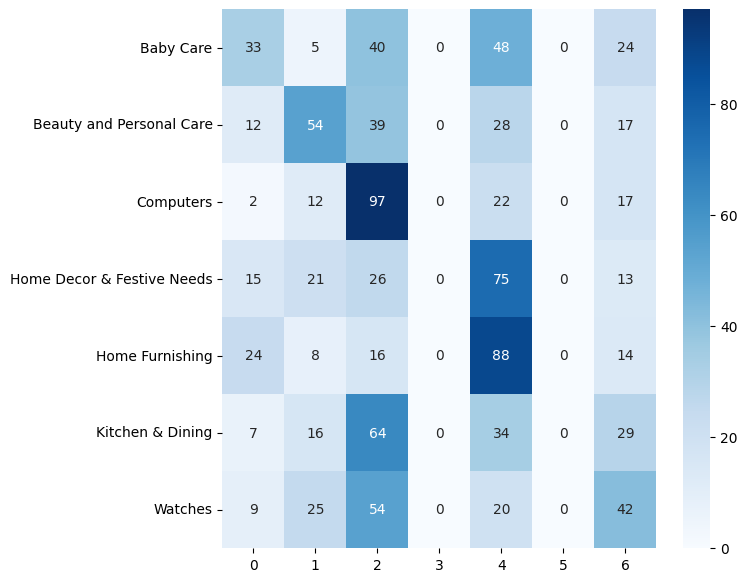

In [15]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)

def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap="Blues")


## MobileNets

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model


In [17]:
# Charger MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False)  # include_top=False pour ne pas inclure les couches de classification

# Créer un modèle pour extraire des caractéristiques des images
model = Model(inputs=base_model.input, outputs=base_model.output)


C:\Users\DELL\AppData\Local\Temp\ipykernel_18740\2626735845.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)  # include_top=False pour ne pas inclure les couches de classification


In [18]:
def extract_mobilenet_features(image_path):
    img = image.load_img(image_path, target_size=(224, 224))  # Redimensionner l'image
    img_array = image.img_to_array(img)  # Convertir l'image en tableau numpy
    img_array_expanded = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour créer un lot de taille 1
    img_preprocessed = preprocess_input(img_array_expanded)  # Prétraiter l'image

    features3 = model.predict(img_preprocessed)  # Prédire les caractéristiques
    features_reduced = features3.reshape(-1)  # Aplatir les caractéristiques pour un usage ultérieur
    return features_reduced


In [19]:
features_reduced = []

# Itérer sur chaque chemin d'image dans le DataFrame
for image_path in df_images['image_path']:
    descriptors = extract_mobilenet_features(image_path)
    features_reduced.append(descriptors)

# Convertir la liste de caractéristiques en un tableau NumPy pour l'utilisation dans des modèles d'apprentissage automatique
features_array = np.array(features_reduced)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

In [20]:
# Les étiquettes ont déjà été encodées dans df_images['label']
labels = df_images['label'].values

In [21]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features_array, labels, test_size=0.2, random_state=42)

# Entraîner un classificateur Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Évaluer le modèle
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.8380952380952381


In [22]:
from sklearn import manifold, decomposition

print(features_array.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(features_array)
print(feat_pca.shape)

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=42, n_iter=1000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")



(1050, 62720)
(1050, 982)
temps de T-SNE :            12.04 secondes


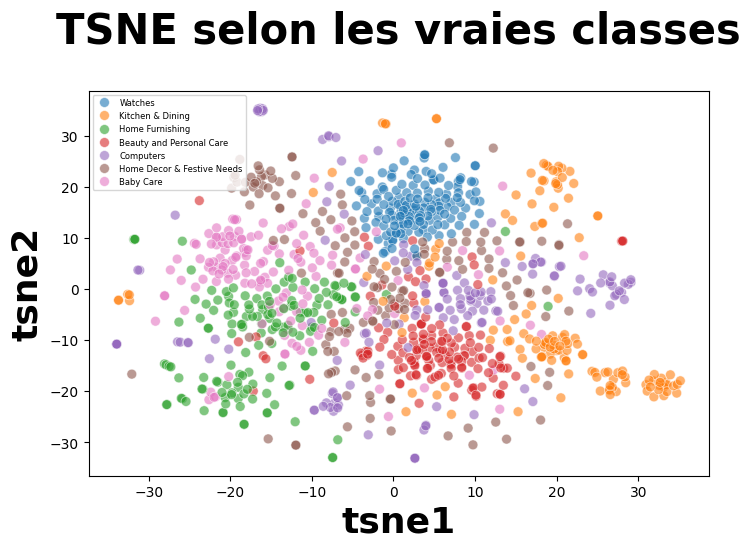

In [23]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_images["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 6}) 

plt.show()


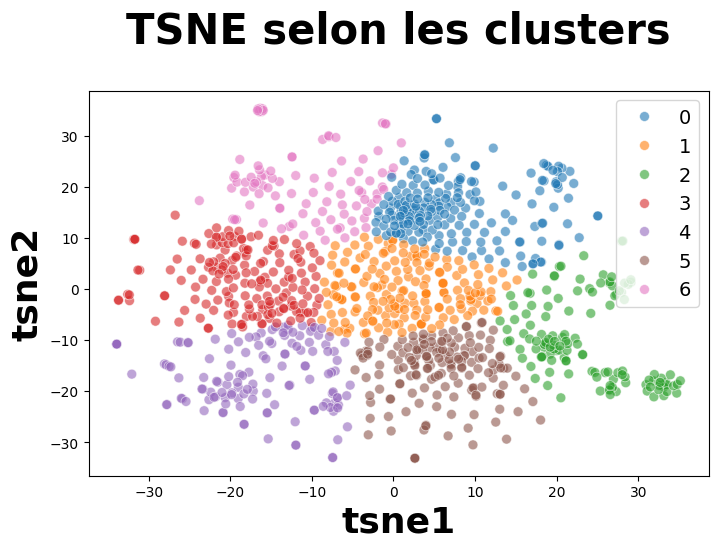

ARI :  0.3045709637992715


In [24]:
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_images["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

# Calcul de l'ARI score
ARI_score = metrics.adjusted_rand_score(labels, cls.labels_)
scores_ari.append(('MobileNets', ARI_score))

Correspondance des clusters :  [6 2 5 0 4 1 3]


<Axes: >

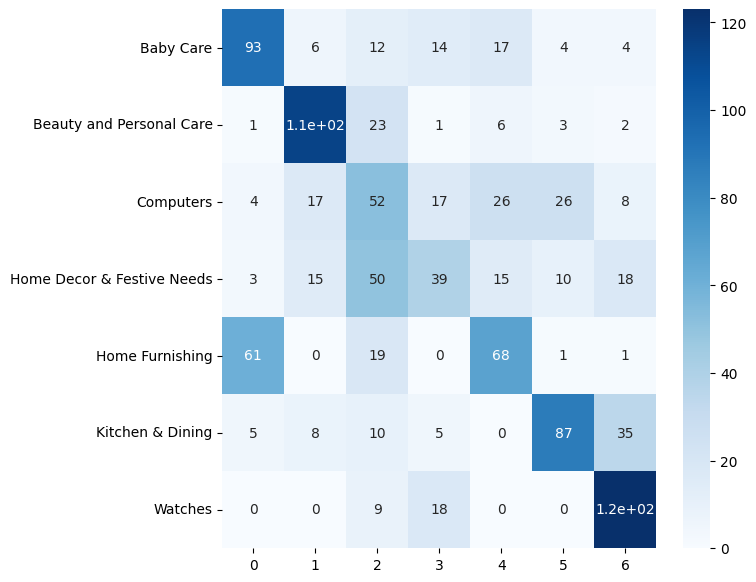

In [25]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)

def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap="Blues")


## EfficientNet

In [26]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0  # B0 est le plus petit modèle
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model

In [27]:
# Charger EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False)  # include_top=False pour ne pas inclure les couches de classification

# Créer un modèle pour extraire des caractéristiques des images
model = Model(inputs=base_model.input, outputs=base_model.output)


In [28]:
def extract_efficientnet_features(image_path):
    img = image.load_img(image_path, target_size=(224, 224))  # EfficientNetB0 utilise une entrée de 224x224 pixels
    img_array = image.img_to_array(img)  # Convertir l'image en tableau numpy
    img_array_expanded = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour créer un lot de taille 1
    img_preprocessed = preprocess_input(img_array_expanded)  # Prétraiter l'image

    features = model.predict(img_preprocessed)  # Prédire les caractéristiques
    features_reduced = features.reshape(-1)  # Aplatir les caractéristiques pour un usage ultérieur
    return features_reduced


In [29]:
features_reduced = []

# Itérer sur chaque chemin d'image dans le DataFrame
for image_path in df_images['image_path']:
    descriptors = extract_efficientnet_features(image_path)
    features_reduced.append(descriptors)

# Convertir la liste de caractéristiques en un tableau NumPy pour l'utilisation dans des modèles d'apprentissage automatique
features_array = np.array(features_reduced)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━

c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━

In [30]:
# Les étiquettes ont déjà été encodées dans df_images['label']
labels = df_images['label'].values

In [31]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features_array, labels, test_size=0.2, random_state=42)

# Entraîner un classificateur Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Évaluer le modèle
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.7904761904761904


In [32]:
from sklearn import manifold, decomposition

print(features_array.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(features_array)
print(feat_pca.shape)

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=42, n_iter=1000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")



(1050, 62720)
(1050, 951)
temps de T-SNE :            10.66 secondes


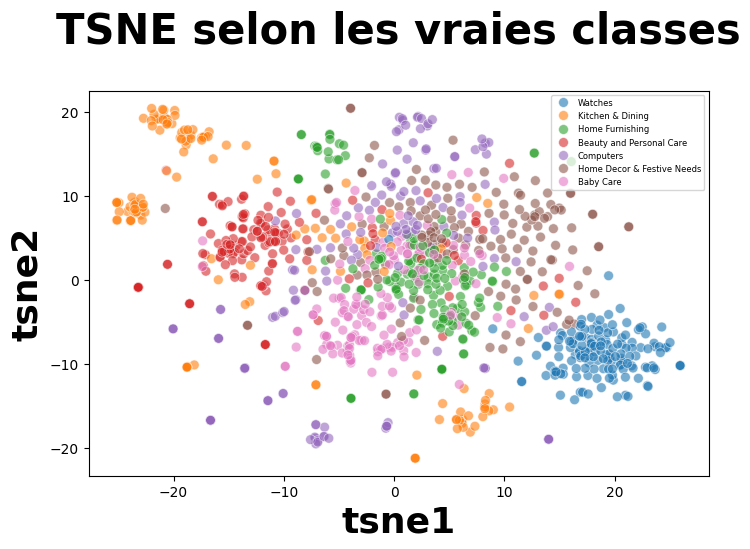

In [33]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_images["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 6}) 

plt.show()


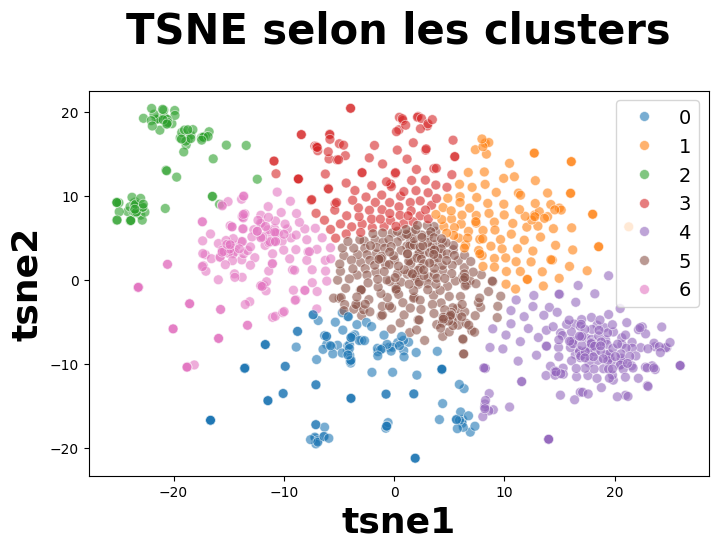

ARI :  0.357651447858625


In [34]:
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_images["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

# Calcul de l'ARI score
ARI_score = metrics.adjusted_rand_score(labels, cls.labels_)
scores_ari.append(('EfficientNet', ARI_score))

Correspondance des clusters :  [0 3 5 2 6 4 1]


<Axes: >

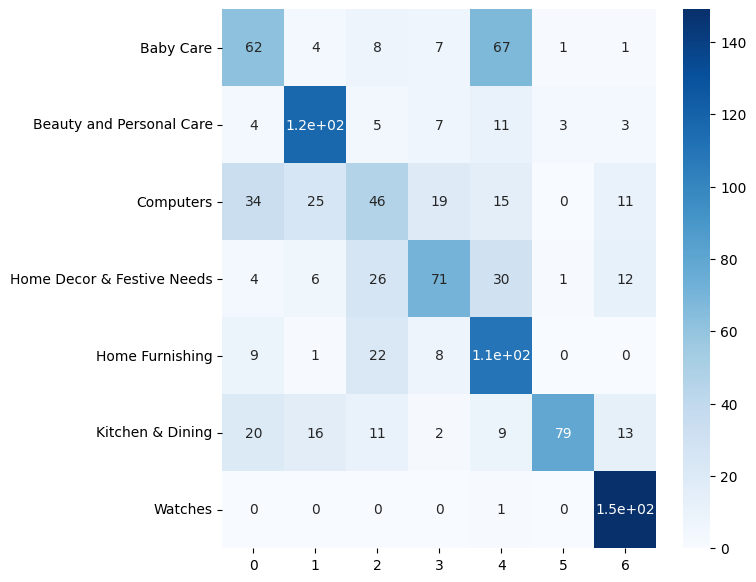

In [35]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)

def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap="Blues")


## ViT

In [36]:
import numpy as np
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import requests

# Charger le feature extractor et le modèle pré-entraîné
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

def extract_vit_features(image_path):
    # Charger l'image et la convertir en format attendu par le modèle ViT
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")

    # Obtenir les sorties du modèle
    outputs = model(**inputs)
    # Extraire les caractéristiques du dernier état caché
    features = outputs.last_hidden_state
    features_reduced = features.mean(dim=1).detach().numpy().flatten()  # Moyenner sur la séquence pour réduire la dimension
    return features_reduced

# Application de la fonction d'extraction des caractéristiques
features = []
for image_path in df_images['image_path']:
    descriptors = extract_vit_features(image_path)
    features.append(descriptors)

# Convertir en tableau NumPy pour la manipulation ultérieure
features_array = np.array(features)


c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompre

In [37]:
# Les étiquettes ont déjà été encodées dans df_images['label']
labels = df_images['label'].values

In [38]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(features_array, labels, test_size=0.2, random_state=42)

# Entraîner un classificateur Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Évaluer le modèle
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.8761904761904762


In [39]:
from sklearn import manifold, decomposition

print(features_array.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(features_array)
print(feat_pca.shape)

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=42, n_iter=1000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")



(1050, 768)
(1050, 531)
temps de T-SNE :             8.57 secondes


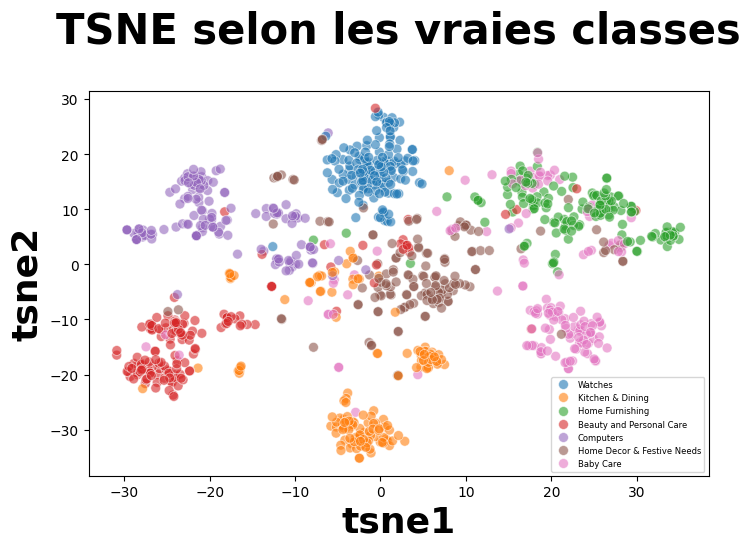

In [40]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_images["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 6}) 

plt.show()


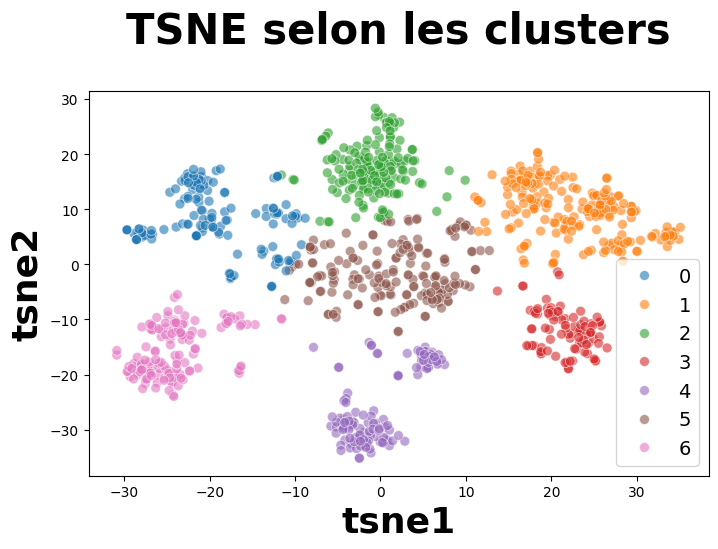

ARI :  0.6315872748172822


In [41]:
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_images["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

# Calcul de l'ARI score
ARI_score = metrics.adjusted_rand_score(labels, cls.labels_)
scores_ari.append(('ViT', ARI_score))

Correspondance des clusters :  [2 4 6 0 5 3 1]


<Axes: >

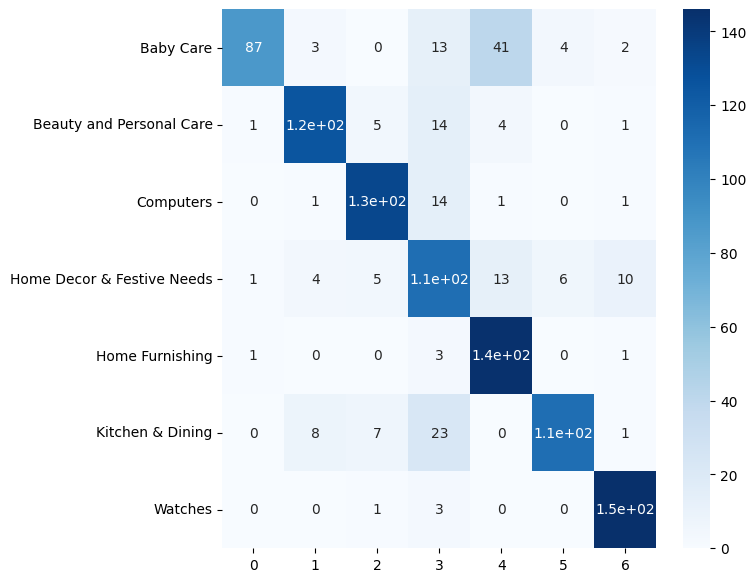

In [42]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)

def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap="Blues")


# Texte

## Réduction USE

In [6]:
# Rejoindre les tokens pour utiliser dans CountVectorizer
data['joined_cleaned_tokens'] = data['cleaned_tokens'].apply(lambda x: ' '.join(x))

# Initialisation du CountVectorizer
vectorizer = CountVectorizer(max_df=0.5, min_df=5, max_features=1000, ngram_range=(1, 2))
X_bow = vectorizer.fit_transform(data['joined_cleaned_tokens'])
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_bow)

# Initialisation du TfidfTransformer pour convertir la matrice BoW en TF-IDF
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_bow)

# Pour utiliser plus tard dans le modèle
data['bow_features'] = list(X_bow.toarray())
data['tfidf_features'] = list(X_tfidf.toarray())

In [7]:
# Fonction pour extraire la première catégorie de 'product_category_tree'
def get_first_category(category_tree):
    if category_tree.startswith('["'):
        categories = category_tree[2:-2].split(' >> ')
        if categories:
            return categories[0]
    return None

# Appliquer la fonction pour créer une nouvelle colonne 'first_category'
data['first_category'] = data['product_category_tree'].apply(get_first_category)

# Liste des catégories valides
list_labels = ["Baby Care", "Beauty and Personal Care", "Computers", "Home Decor & Festive Needs", "Home Furnishing", "Kitchen & Dining", "Watches"]

# Associer les catégories aux images
data['label_name'] = data['uniq_id']

# Encoder les labels
le = preprocessing.LabelEncoder()
le.fit(data['label_name'])
data['label'] = le.transform(data['label_name'])

c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


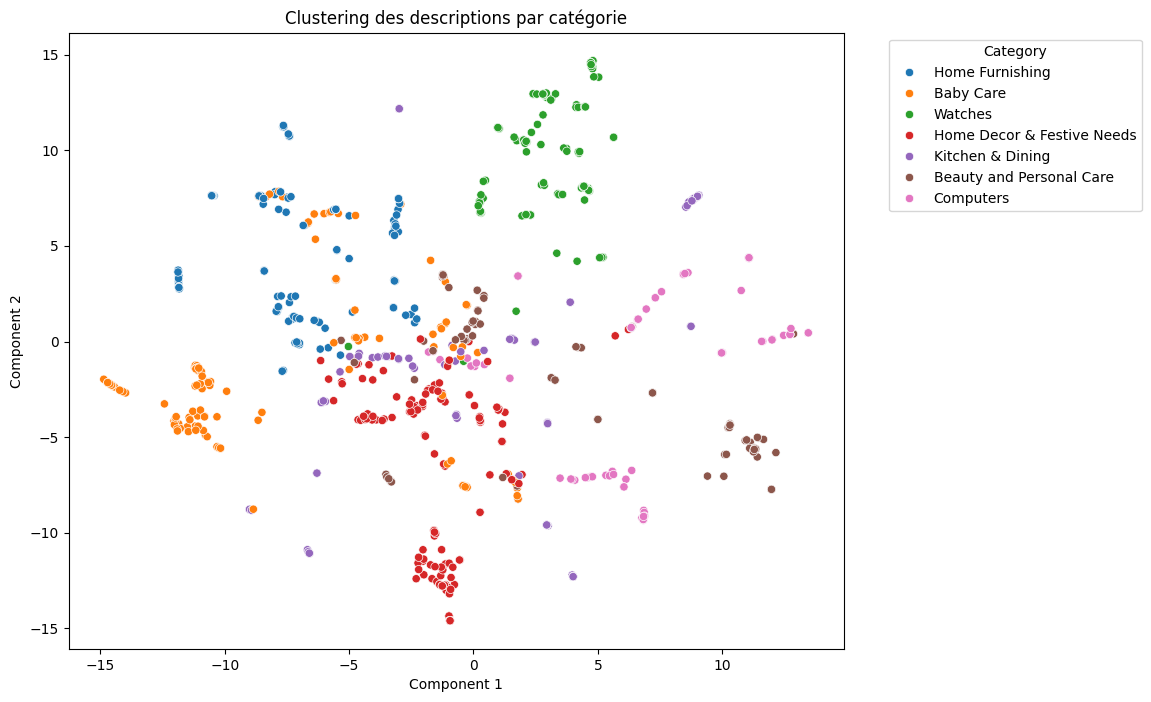

In [8]:
# Réduction de dimension avec PCA ou T-SNE
pca = PCA(n_components=50)  # Réduire d'abord la dimensionnalité avec PCA
X_pca = pca.fit_transform(X_tfidf.toarray())

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_pca)

# Clustering
kmeans = KMeans(n_clusters=7)  # Choisissez le nombre approprié de clusters
clusters = kmeans.fit_predict(X_tsne)

# Préparation des données pour la visualisation
plot_data = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
plot_data['Category'] = data['first_category']

# Visualisation des clusters avec des couleurs par catégorie
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Component 1', y='Component 2', hue='Category', data=plot_data)
plt.title('Clustering des descriptions par catégorie')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

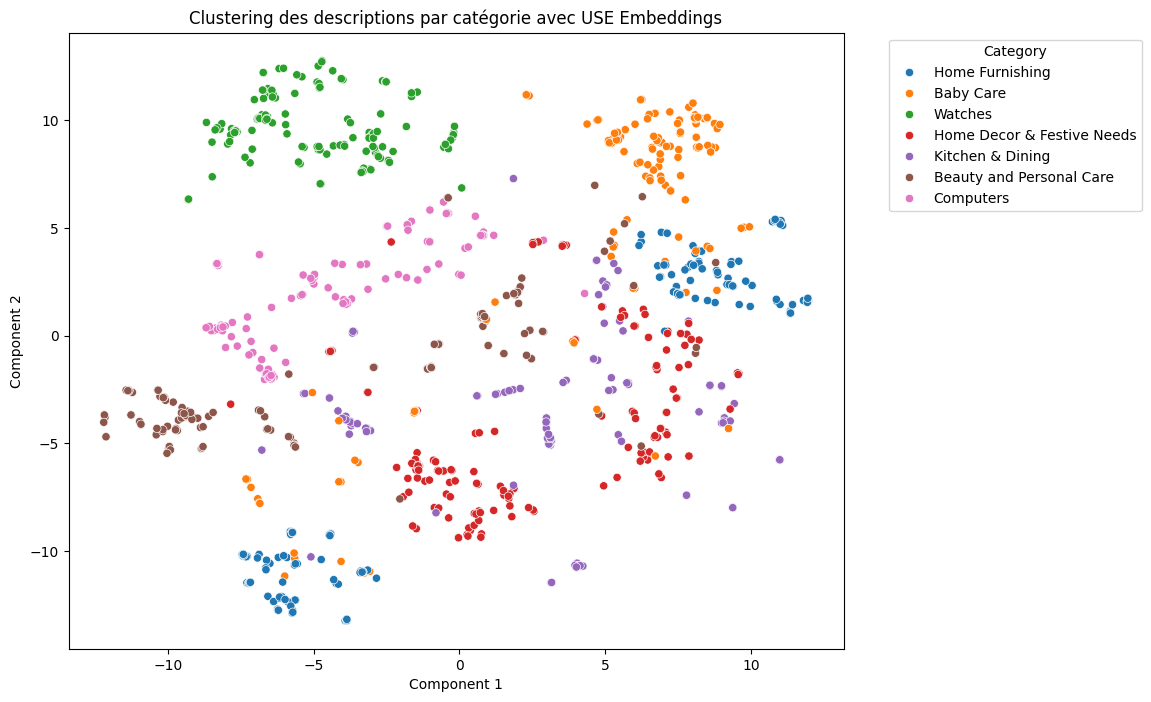

In [9]:
import tensorflow_hub as hub

# Chargement du modèle Universal Sentence Encoder de TensorFlow Hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Application du modèle USE pour obtenir des embeddings des descriptions
X_embed = embed(data['description'])

# Réduction de dimension avec T-SNE (aucune réduction PCA préalable nécessaire ici car les embeddings USE sont déjà de dimension gérable)
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_embed.numpy())

# Préparation des données pour la visualisation
plot_data = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
plot_data['Category'] = data['first_category'] 

# Visualisation des clusters avec des couleurs par catégorie
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Component 1', y='Component 2', hue='Category', data=plot_data)
plt.title('Clustering des descriptions par catégorie avec USE Embeddings')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [10]:
# Clustering avec K-Means
kmeans = KMeans(n_clusters=7)  # Ajustez le nombre de clusters si nécessaire
clusters = kmeans.fit_predict(X_tsne)

c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ARI score: 0.4094788735883326


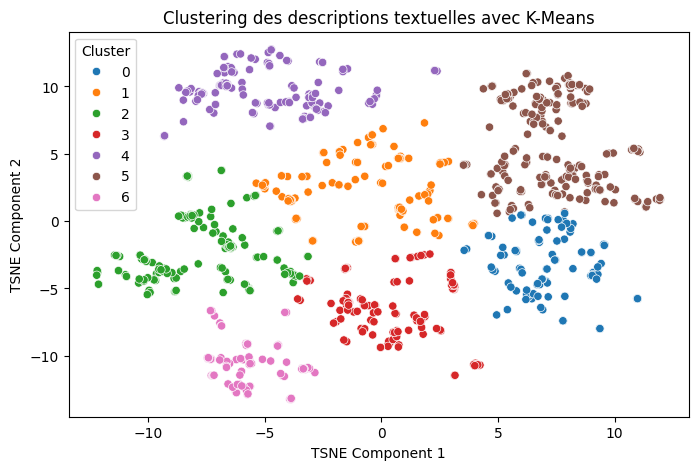

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import cluster, metrics

# Associer les catégories aux descriptions en utilisant la colonne 'first_category' déjà présente dans 'data'
data['label_name'] = data['first_category']

# Encoder les labels avec LabelEncoder pour les convertir en format numérique
le = preprocessing.LabelEncoder()
le.fit(data['label_name'])
data['label'] = le.transform(data['label_name'])

# Vous pouvez maintenant utiliser 'data['label']' pour calculer le score ARI
ARI_score = metrics.adjusted_rand_score(data['label'], kmeans.labels_)
print("ARI score:", ARI_score)

# Visualisation des clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=kmeans.labels_, palette=sns.color_palette("tab10", n_colors=7))
plt.title('Clustering des descriptions textuelles avec K-Means')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend(title='Cluster')
plt.show()


In [12]:
import pandas as pd

# Crée un DataFrame avec les clusters et les catégories réelles
cluster_labels = pd.DataFrame({'Cluster': kmeans.labels_, 'True_Label': data['first_category']})

# Trouve la catégorie la plus fréquente dans chaque cluster
cluster_to_category = {}
for cluster in cluster_labels['Cluster'].unique():
    # Utiliser mode() de Pandas pour obtenir la catégorie la plus fréquente
    mode_category = cluster_labels[cluster_labels['Cluster'] == cluster]['True_Label'].mode()[0]
    cluster_to_category[cluster] = mode_category

# Associe chaque cluster à sa catégorie la plus fréquente
cluster_labels['Predicted_Category'] = cluster_labels['Cluster'].map(cluster_to_category)

# Affiche le mapping de cluster à catégorie pour vérification
print(cluster_to_category)

from sklearn.metrics import accuracy_score

# Calculer l'accuracy
accuracy = accuracy_score(cluster_labels['True_Label'], cluster_labels['Predicted_Category'])
print("Accuracy:", accuracy)



{5: 'Baby Care', 4: 'Watches', 6: 'Home Furnishing', 0: 'Kitchen & Dining', 1: 'Computers', 3: 'Home Decor & Festive Needs', 2: 'Beauty and Personal Care'}
Accuracy: 0.5906542056074766


In [13]:
import numpy as np

def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [14]:
cls_labels_transform = conf_mat_transform(data['label'], kmeans.labels_)
conf_mat = metrics.confusion_matrix(data['label'], cls_labels_transform)
print(conf_mat)

Correspondance des clusters :  [5 2 1 3 6 0 4]
[[103   2   5  10  22   3   5]
 [  7  80  58   1   0   4   0]
 [  1  75  74   0   0   0   0]
 [ 10   8   7  73   0  52   0]
 [ 75   0   0   0  74   1   0]
 [ 12  16   7  55   1  79   0]
 [  0   0   1   0   0   0 149]]


<Axes: >

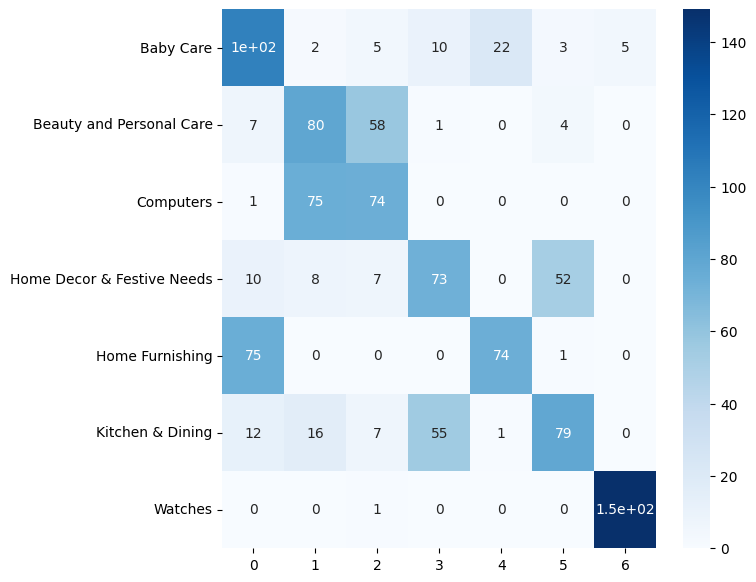

In [15]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## BERT

In [16]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Charge et prépare ton modèle BERT
num_labels = len(list_labels)  # Assure-toi que cette variable est correctement définie
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Encode les descriptions
def encode_data(tokenizer, text_list, max_length):
    input_ids = []
    attention_masks = []
    for text in text_list:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    return input_ids, attention_masks

# Encode les étiquettes
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(data['label'])
labels = torch.tensor(encoded_labels, dtype=torch.long)

# Préparation des données
max_length = 128
input_ids, attention_masks = encode_data(tokenizer, data['description'].tolist(), max_length)

# Créer le DataLoader
batch_size = 8
dataset = TensorDataset(input_ids, attention_masks, labels)
dataloader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=batch_size)

# Boucle d'entraînement
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Pour calculer l'accuracy
def calculate_accuracy(preds, labels):
    pred_flat = preds.argmax(dim=1).flatten()
    labels_flat = labels.flatten()
    return torch.sum(pred_flat == labels_flat).item() / len(labels_flat)

model.train()
total_accuracy = 0
for batch in dataloader:
    b_input_ids, b_input_mask, b_labels = batch
    model.zero_grad()        
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs.loss
    logits = outputs.logits
    loss.backward()
    optimizer.step()

    # Calcul de l'accuracy pour le batch
    batch_accuracy = calculate_accuracy(logits, b_labels)
    total_accuracy += batch_accuracy

# Moyenne de l'accuracy sur tous les batches
average_accuracy = total_accuracy / len(dataloader)
print(f"Entraînement terminé. Accuracy moyenne: {average_accuracy:.4f}")


c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Entraînement terminé. Accuracy moyenne: 0.6343


In [18]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

test_dataloader = DataLoader(dataset , sampler=SequentialSampler(dataset), batch_size=batch_size)

In [19]:
# Déterminer si CUDA (GPU) est disponible et définir le périphérique en conséquence
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assure-toi que le modèle est aussi envoyé sur ce périphérique
model = model.to(device)


In [20]:
import numpy as np
from sklearn.metrics import adjusted_rand_score

model.eval()  # Mettre le modèle en mode évaluation
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():  # Désactive le calcul du gradient pour l'évaluation
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    predictions.append(logits)
    true_labels.append(label_ids)

# Convertir les listes en un seul tableau
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Prédire les classes à partir des logits
predicted_labels = np.argmax(predictions, axis=1)

# Calculer l'ARI
ari_score = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")


Adjusted Rand Index (ARI): 0.8697


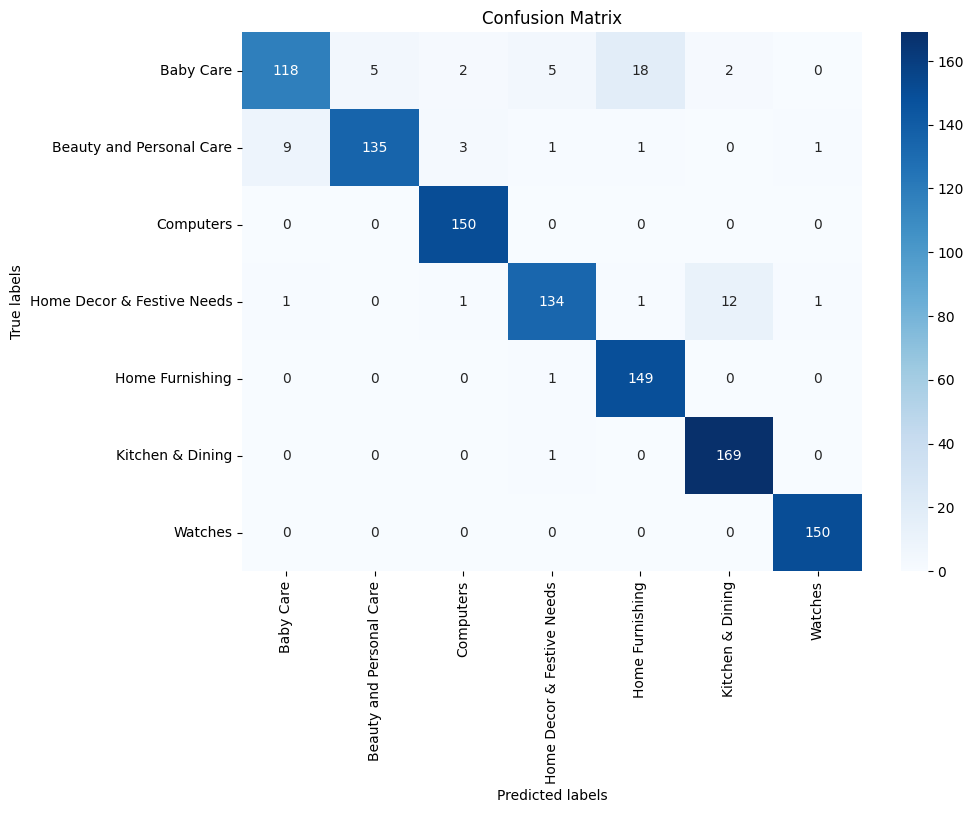

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_labels, labels=np.arange(len(list_labels)))

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=list_labels, yticklabels=list_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


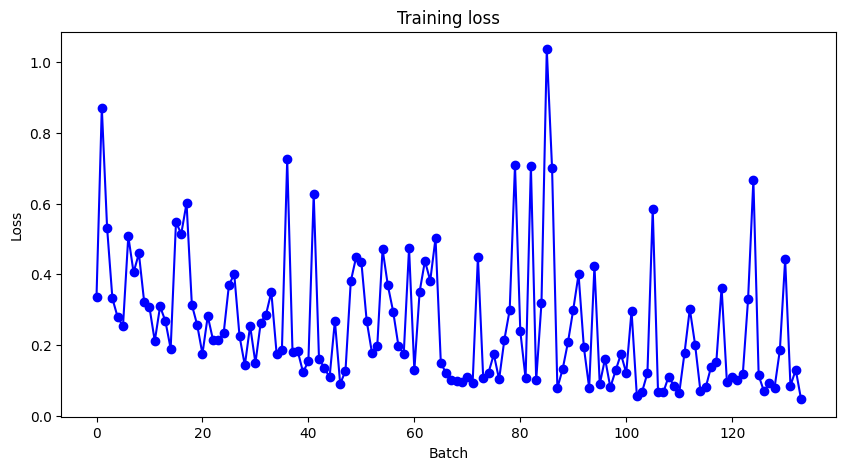

In [22]:
loss_values = []

for batch in dataloader:
    b_input_ids, b_input_mask, b_labels = batch
    model.zero_grad()        
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    
    loss_values.append(loss.item())

# Tracer la courbe de perte
plt.figure(figsize=(10,5))
plt.plot(loss_values, 'b-o')
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()


## Word2Vec

In [5]:
# Charger le modèle anglais de spaCy
nlp = spacy.load('en_core_web_sm')

# Fonction pour nettoyer le texte
def clean_text(text):
    # Tokenisation du texte
    tokens = word_tokenize(text)
    # Suppression de la ponctuation et mise en minuscule
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # Suppression des mots vides (stop words)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Fonction pour appliquer le stemming
def stem_text(tokens):
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in tokens]
    return stemmed

# Fonction pour appliquer la lemmatisation
def lemmatize_text(tokens):
    doc = spacy.tokens.Doc(nlp.vocab, words=tokens)
    lemmatized = [token.lemma_ for token in nlp(doc)]
    return lemmatized

# Application des fonctions sur la colonne 'description'
data['description'] = data['description'].fillna('') 
data['cleaned_tokens'] = data['description'].apply(clean_text)

In [6]:
import codecs

def check_vector_dimensions(file_path):
    with open(file_path, 'r') as file:
        first_line = True
        for line in file:
            parts = line.strip().split()
            if first_line:
                first_line = False  # La première ligne contient le nombre de mots et la dimension, l'ignorer
                continue
            if len(parts) != 101:  # 1 mot + 100 dimensions
                print(f"Erreur de dimension trouvée : {line}")
                break

# Chemin d'accès au fichier
word2vec_output_file = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/glove.6B.100d.txt.word2vec'
check_vector_dimensions(word2vec_output_file)

def convert_glove_to_word2vec(glove_input_path, word2vec_output_path):
    with codecs.open(glove_input_path, 'r', encoding='latin-1') as glove_file:
        with open(word2vec_output_path, 'w', encoding='utf-8') as word2vec_file:
            valid_lines = []
            for line in glove_file:
                parts = line.strip().split()
                if len(parts) == 101:  # 1 mot + 100 dimensions
                    valid_lines.append(line)
            # Écrire l'en-tête avec le nombre correct de lignes et de dimensions
            word2vec_file.write(f"{len(valid_lines)} 100\n")
            for line in valid_lines:
                word2vec_file.write(line)

glove_input_file = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/glove.6B.100d.txt'
word2vec_output_file = 'C:/Users/DELL/Desktop/OpenClass/Formation/Projet_006/glove.6B.100d.txt.word2vec'
convert_glove_to_word2vec(glove_input_file, word2vec_output_file)




In [7]:
from gensim.models import KeyedVectors

# Charger les vecteurs GloVe convertis
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)


def document_vector(doc):
    # Supprimer les mots que le modèle ne connaît pas
    doc = [word for word in doc if word in model.key_to_index]
    # Vérifier si la liste après le filtrage est vide
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(model[doc], axis=0)

data['w2v_features'] = data['cleaned_tokens'].apply(document_vector)


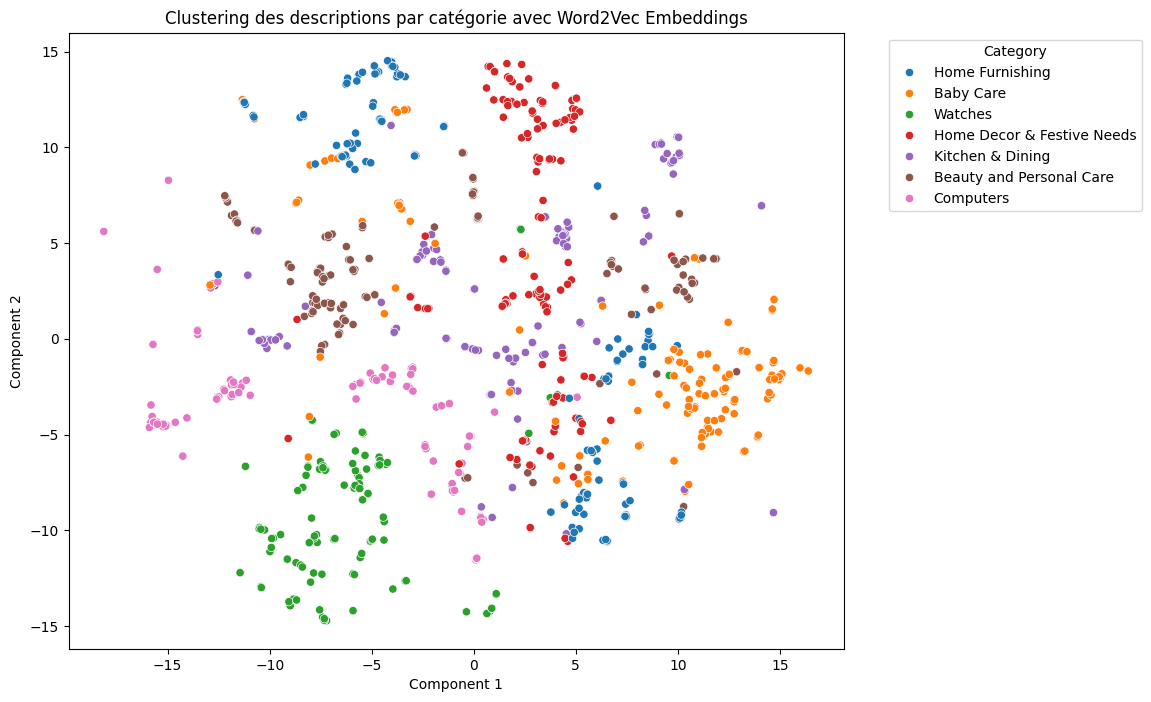

c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


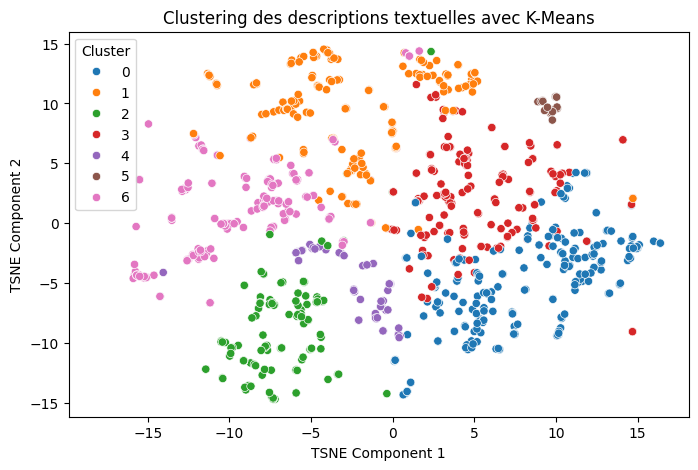

1070 1070


ValueError: Input contains NaN

In [9]:
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_w2v = np.array(list(data['w2v_features']))  # Convert feature list to numpy array once

# Réduction de dimension avec T-SNE
tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
X_tsne = tsne.fit_transform(X_w2v)

# Visualisation des clusters avec T-SNE result
plt.figure(figsize=(10, 8))
plot_data = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
plot_data['Category'] = data['first_category']
sns.scatterplot(x='Component 1', y='Component 2', hue='Category', data=plot_data)
plt.title('Clustering des descriptions par catégorie avec Word2Vec Embeddings')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Clustering avec K-Means
kmeans = KMeans(n_clusters=7)
clusters = kmeans.fit_predict(X_w2v)  # Ensure this uses the cleaned and consistent data

# Visualisation des clusters K-Means
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=kmeans.labels_, palette=sns.color_palette("tab10", n_colors=7))
plt.title('Clustering des descriptions textuelles avec K-Means')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend(title='Cluster')
plt.show()

# Ensure the lengths are the same
print(len(data['label']), len(clusters))

# Calculate ARI score
ARI_score = metrics.adjusted_rand_score(data['label'], clusters)
print("ARI score:", ARI_score)

def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']



In [ ]:
import numpy as np

def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [ ]:
cls_labels_transform = conf_mat_transform(data['label'], kmeans.labels_)
conf_mat = metrics.confusion_matrix(data['label'], cls_labels_transform)
print(conf_mat)

Correspondance des clusters :  [4 5 5 3 6 0 2]
[[ 90   0   1  15  18  26   0]
 [  5   0  43  26  32  44   0]
 [  3   0  58  20  16  53   0]
 [ 16   0  12  58   6  58   0]
 [ 41   0   0  18  56  35   0]
 [ 13   0  10  13  28 106   0]
 [  1   0   0   0   0  15 134]]


<Axes: >

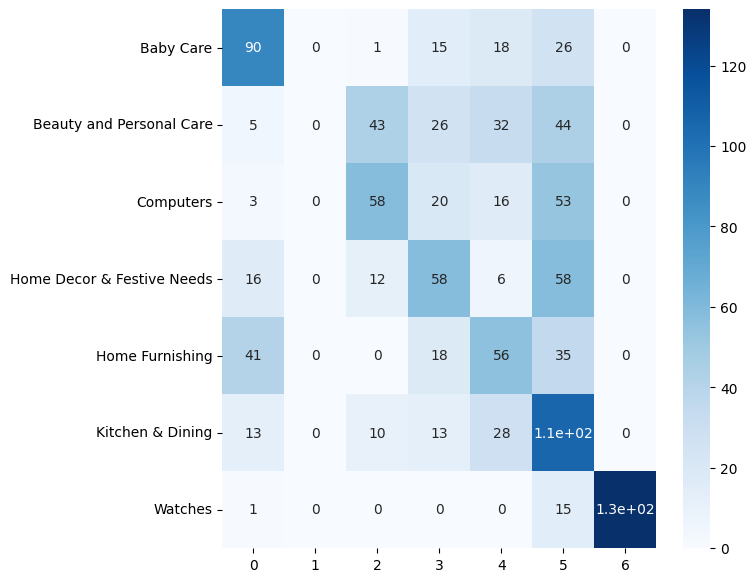

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Glove

In [ ]:
import os
import urllib.request
import zipfile

# URL du fichier zip de GloVe
url = "http://nlp.stanford.edu/data/glove.6B.zip"
zip_path = "glove.6B.zip"
extract_folder = "."

# Télécharger le fichier zip de GloVe
if not os.path.exists(zip_path):
    print("Téléchargement de GloVe...")
    urllib.request.urlretrieve(url, zip_path)
    print("Téléchargé.")

# Extraire le fichier zip
if not os.path.exists(os.path.join(extract_folder, "glove.6B.100d.txt")):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print("Extraction terminée.")

# Spécifier le chemin d'accès aux fichiers de GloVe
glove_input_file = os.path.join(extract_folder, 'glove.6B.100d.txt')
word2vec_output_file = 'glove.6B.100d.txt.word2vec'

# Convertir le fichier de GloVe au format word2vec
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file, word2vec_output_file)

# Charger le modèle
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)


C:\Users\DELL\AppData\Local\Temp\ipykernel_8464\2577741548.py:28: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [ ]:
def vectorize_text(text, model, vector_size):
    vectors = [model[word] for word in text if word in model]
    if not vectors:  # gestion des cas où il n'y a aucun vecteur valide
        return np.zeros(vector_size)
    else:
        return np.mean(vectors, axis=0)

# Appliquer la vectorisation sur les données nettoyées
data['vector'] = data['cleaned_tokens'].apply(lambda x: vectorize_text(x, glove_model, 100))


In [ ]:
# Convertir toutes les étiquettes en chaînes de caractères
data['label'] = data['label'].apply(str)

# Vérifier les types pour confirmer la conversion
print(data['label'].apply(type).value_counts())
from sklearn.preprocessing import LabelEncoder

# Initialisation de l'encodeur de labels
label_encoder = LabelEncoder()

# Adapter l'encodeur aux étiquettes et les transformer
data['encoded_labels'] = label_encoder.fit_transform(data['label'])

# Vérifier les nouvelles étiquettes encodées
print(data[['label', 'encoded_labels']].head())
import torch
import numpy as np

# Conversion en tenseurs après traitement
features = torch.tensor(np.stack(data['vector'].values).astype(np.float32))
labels = torch.tensor(data['encoded_labels'].values.astype(np.int64))

# Création d'un TensorDataset et DataLoader
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(features, labels)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


label
<class 'str'>    1070
Name: count, dtype: int64
  label  encoded_labels
0   nan              17
1   nan              17
2   nan              17
3   nan              17
4   nan              17


In [ ]:
# Exemple de boucle d'entraînement pour tester
try:
    model.train()
    for batch in dataloader:
        optimizer.zero_grad()
        batch_features, batch_labels = batch
        batch_features = batch_features.float()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
    print("Aucune erreur rencontrée pendant l'entraînement de test.")
except Exception as e:
    print("Erreur rencontrée :", e)


Erreur rencontrée : name 'model' is not defined


In [ ]:
import torch.nn as nn

class TextClassifier(nn.Module):
    def __init__(self, num_labels):
        super(TextClassifier, self).__init__()
        self.fc = nn.Linear(100, num_labels)  # 100 pour la taille du vecteur GloVe utilisé

    def forward(self, x):
        x = self.fc(x)
        return x

# Création de l'instance du modèle
model = TextClassifier(num_labels=18)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Boucle d'entraînement
model.train()
for epoch in range(10):  # nombre d'époques
    for batch in dataloader:
        batch_features, batch_labels = batch
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 1, Loss: 1.1882368326187134
Epoch 2, Loss: 0.35387468338012695
Epoch 3, Loss: 0.20059654116630554
Epoch 4, Loss: 0.1114877462387085
Epoch 5, Loss: 0.08688737452030182
Epoch 6, Loss: 0.0740095004439354
Epoch 7, Loss: 0.4269542396068573
Epoch 8, Loss: 0.04774826020002365
Epoch 9, Loss: 0.03350632265210152
Epoch 10, Loss: 0.3033450245857239


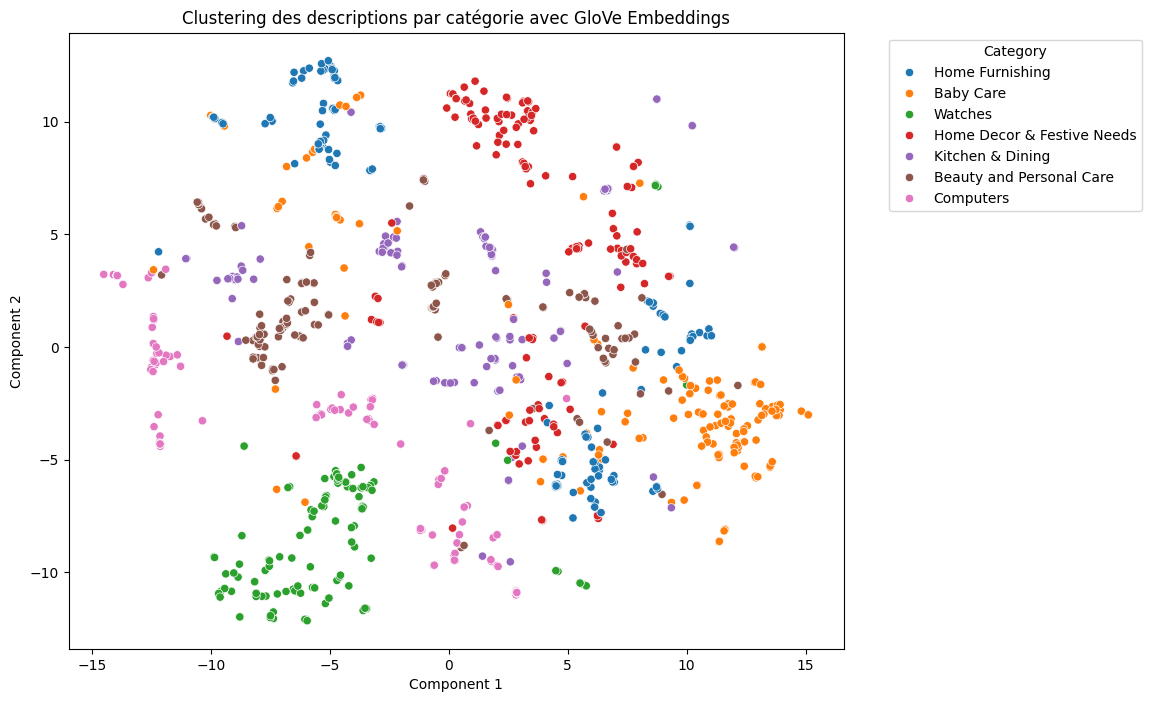

c:\Users\DELL\anaconda3\envs\2024\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


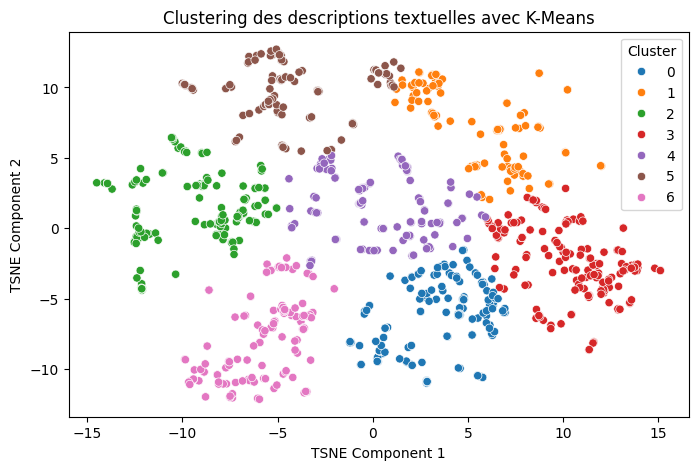

ARI score: 0.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics

# Assure-toi que tous les vecteurs soient dans un format approprié (pas de NaNs)
data = data.dropna(subset=['vector'])
X_glove = np.stack(data['vector'].values)  # Assure-toi que les vecteurs sont déjà dans le format approprié

# Réduction de dimension avec T-SNE
tsne = TSNE(n_components=2, perplexity=20, n_iter=300)
X_tsne = tsne.fit_transform(X_glove)

# Visualisation des clusters comme auparavant
plt.figure(figsize=(10, 8))
plot_data = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
plot_data['Category'] = data['first_category']
sns.scatterplot(x='Component 1', y='Component 2', hue='Category', data=plot_data)
plt.title('Clustering des descriptions par catégorie avec GloVe Embeddings')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Clustering avec K-Means
kmeans = KMeans(n_clusters=7)
clusters = kmeans.fit_predict(X_tsne)

# Visualisation des clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=kmeans.labels_, palette=sns.color_palette("tab10", n_colors=7))
plt.title('Clustering des descriptions textuelles avec K-Means')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend(title='Cluster')
plt.show()

# Calcul de l'ARI score
ARI_score = metrics.adjusted_rand_score(data['label'], kmeans.labels_)
print("ARI score:", ARI_score)
